<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Principle Component Analysis**


![img](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/images/PCA.jpeg)

Estimated time needed: **45** minutes


## Use cases of PCA

*   Facial Recognition
*   Image Compression
*   Finding patterns in data of high dimension in the field of quantitative finance.

For instance, suppose you are a fund manager who has 200 stocks in a portfolio. To analyze the potential movements and relationships of the stocks, you would need to  at least work with a 200$\times$200 correlation or covariance matrix, which is very complex.

However, instead of looking at 200 stock variances, would it be more efficient to just look at 10 most dominant/principal directions of variances that best represent the original variances of the stocks?

PCA is a methodology to reduce the dimensionality of a complex problem.

<img src='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/images/fundmanager.jpg' style="width: 70%">


In this notebook, you will explore how to simplify and reduce the dimensionality of various data using **principle component analysis** (PCA)


***


After completing this lab you will be able to:


*   **Understand** what PCA is and how (generally) it works.
*   **Understand** when PCA is useful.
*   **Apply** PCA effectively.


## Datasets

Datasets for this lab are gathered from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01) under the MIT License.


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install pandas==1.3.4 ..."

### Importing Required Libraries


In [1]:
# Surpress warnings from using older version of sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from scipy.stats import loguniform

warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

### Defining Helper Functions

Below, we define helper functions to simplify your code later on:


In [2]:
def plot_explained_variance(pca):
    # This function graphs the accumulated explained variance ratio for a fitted PCA object.
    acc = [*accumulate(pca.explained_variance_ratio_)]
    fig, ax = plt.subplots(1, figsize=(50, 20))
    ax.stackplot(range(pca.n_components_), acc)
    ax.scatter(range(pca.n_components_), acc, color='black')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, pca.n_components_-1)
    ax.tick_params(axis='both', labelsize=36)
    ax.set_xlabel('N Components', fontsize=48)
    ax.set_ylabel('Accumulated explained variance', fontsize=48)
    plt.tight_layout()
    plt.show()

## Background

Before we begin using **PCA**, we should first understand:

1.  What PCA does
2.  How PCA Works


### What does PCA do?

*   Reduces the dimensionality of data. By reducing data dimensionality, PCA can also help with visualization.
*   May reduce noise in the process

\-Can be used to pre-process data improving the result of your algorithm


### How does PCA work? (optional)

1.  Looks at an $n$ -dimensional dataset and breaks it down into "general trends" or **components**

```
- When we say "$n$-dimensional", we mean the data has $n$ features.
```

2.  The components are then **sorted by how much of the explained variance they account for** (*eigenvalues* provide this information)

```
- This means if a component is highly-uncorrelated with all others, it's a "strong" component and provides useful information that is very hard to infer from all other components.
```

3.  Then, given some parameter (usually chosen by the data engineer), the new dimension of the data is decided. Let this be $k$.

```
- Note $k$ is always $k \leq n$ because we're only trying to reduce the dimension of our data.
```

4.  Finally, the original $n$ dimensional dataset is projected onto the $k$-dimensional plane chosen by our **top-$k$ components that take care of the most explained variance**.

```
- These top- $k$ components are now used 
```

Because principle components span an (at most) $k$-dimensional surface, we have successfully reduced our data to at least $k \leq n$ dimensions!


## Visual Example

Let's look at an example that will visually demonstrate PCA in action.

Load the dataset `HeightsWeights.csv` which contains a list of various people's heights (in inches) and weight (in pounds and kg):


In [3]:
hwdf = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/HeightsWeights.csv', index_col=0)
hwdf.tail()

,Height(Inches),Weight(Pounds),Weight(Kilograms)
Index,,,
24996,69.50215,118.0312,53.538601
24997,64.54826,120.1932,54.519278
24998,64.69855,118.2655,53.644879
24999,67.52918,132.2682,59.996462
25000,68.87761,124.8742,56.642566


### Scaling data

You should (almost) always **scale your data** before applying PCA**

**Why?**: There are many reasons, here are some:

*   Scaling your features make the features have the same standard deviation => same weight.

*   If the features have the same weight, PCA is able to best find the most significant components (principal components) without being biased towards features with high variance.

*   Computers do not do well in adding large numbers and small numbers, so, if all data is in the same range  algorithms usually perform better.

Let's use the `StandardScaler` from `sklearn.preprocessing`:


In [5]:
scaler = StandardScaler()
hwdf[:] = scaler.fit_transform(hwdf)
hwdf.columns = [f'{c} (scaled)' for c in hwdf.columns]  # Hanya mengganti/update nama columns aja
hwdf.head()

,Height(Inches) (scaled),Weight(Pounds) (scaled),Weight(Kilograms) (scaled)
Index,,,
1,-1.162051,-1.208072,-1.208072
2,1.852136,0.806805,0.806805
3,0.739165,2.225214,2.225214
4,0.117523,1.308328,1.308328
5,-0.107961,1.476561,1.476561


Let's look at 3-D plot of our data (one dimension per feature):


In [10]:
for i in range(2):
    print(i+1)

1
2


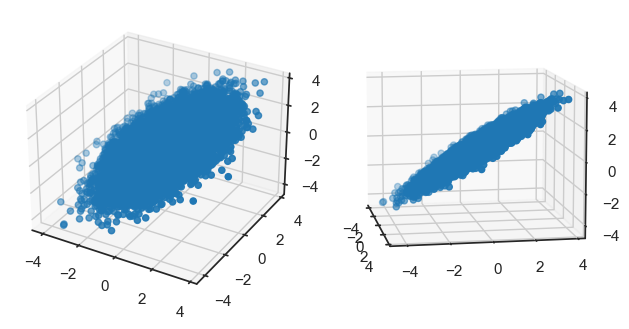

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax1.scatter(xs, ys, zs)

ax2 = fig.add_subplot(122, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax2.view_init(elev=10, azim=-10)
ax2.scatter(xs, ys, zs)

plt.tight_layout()
plt.show()

In [23]:
hwdf.shape

(25000, 3)

As you can see, our data here forms a plane.

This is because the *weight in kilograms does not provide any more information than weight in pounds* (or vice-versa).

This becomes clear with the following, alternate perspective, showing the 2d relationships between the pairs of data and calculating the correlation  :


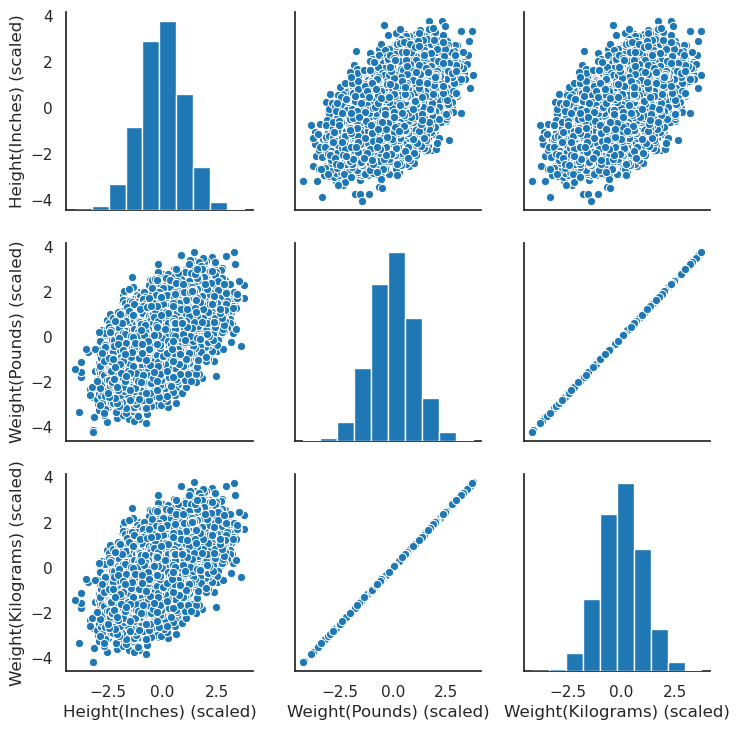

In [6]:
sns.pairplot(hwdf)
plt.show()

In [24]:
hwdf.corr().style.background_gradient(cmap='coolwarm')

,Height(Inches) (scaled),Weight(Pounds) (scaled),Weight(Kilograms) (scaled)
Height(Inches) (scaled),1.000000,0.502859,0.502859
Weight(Pounds) (scaled),0.502859,1.000000,1.000000
Weight(Kilograms) (scaled),0.502859,1.000000,1.000000


We see the weights are perfectly correlated, which means **Weight(Pounds)** tells us everything we need to know about **Weight(Kilograms)** ,thus we have clearly **redundant** data! Although, this example is exaggerated, it'll help demonstrate where PCA shines.


<b>Note</b> Standardizing your data before applying PCA is called *whitening*.


### Applying PCA

It's time to apply PCA, let's first apply PCA keeping the same dimension as the original data, i.e.: `n_components=3`.


In [25]:
pca = PCA()
pca.fit(hwdf)

print(pca.explained_variance_ratio_)
Xhat = pca.transform(hwdf)
print(Xhat.shape)

[7.89776424e-01 2.10223576e-01 7.44272857e-32]
(25000, 3)


In [53]:
Xhat[:,0]

array([ 2.05177404, -1.86621756, -3.13343602, ...,  1.74714297,
       -0.44603329,  0.02297914])

In [71]:
Xhat[0:,0]

array([ 2.05177404, -1.86621756, -3.13343602, ...,  1.74714297,
       -0.44603329,  0.02297914])

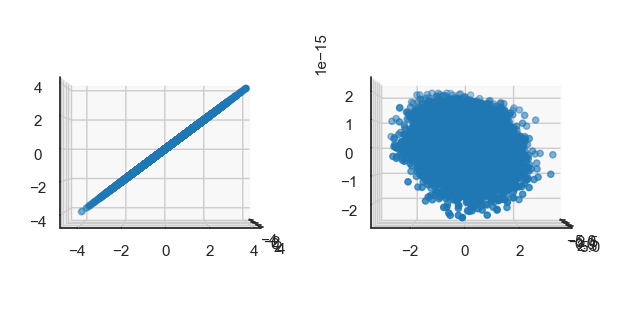

In [80]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax1.view_init(elev=0, azim=0)
ax1.scatter(xs, ys, zs)

ax2 = fig.add_subplot(122, projection='3d')
xs, ys, zs = [Xhat[0:,attr] for attr in range(Xhat.shape[1])]
ax2.view_init(elev=0, azim=0)
ax2.scatter(xs, ys, zs)

plt.tight_layout()
plt.show()

Let’s look at the new dataset as a dataframe.


In [28]:
hwdf_PCA = pd.DataFrame(columns=[f'Projection on Component {i+1}' for i in range(len(hwdf.columns))], data=Xhat)
hwdf_PCA.tail()

,Projection on Component 1,Projection on Component 2,Projection on Component 3
24995,0.608133,1.210008,4.440892e-16
24996,1.576087,-1.222719,1.665335e-16
24997,1.747143,-1.044829,-2.220446e-16
24998,-0.446033,-0.506547,-1.665335e-16
24999,0.022979,0.536042,-2.498002e-16


**Why** are the values in the third column all essentially zero?

Let's look at the principle components:


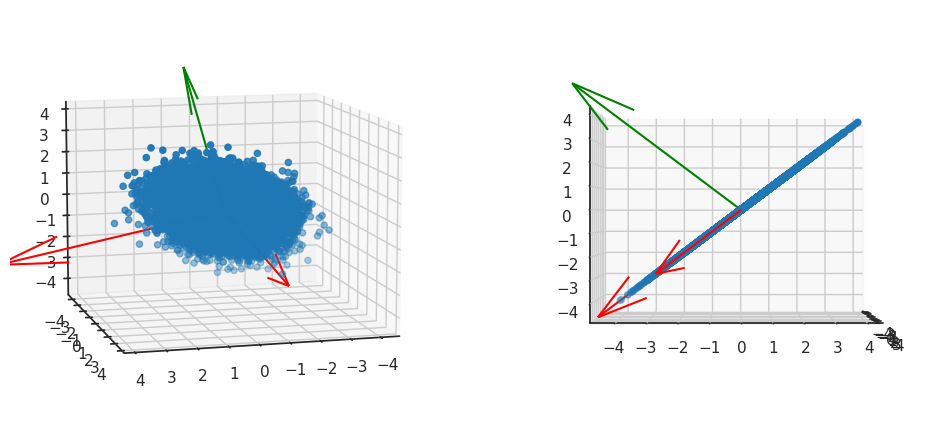

red component accounts for 78.98% of explained variance
red component accounts for 21.02% of explained variance
green component accounts for 0.00% of explained variance


In [31]:
colors = ['red', 'red', 'green']

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax1.view_init(elev=10, azim=75)
ax1.scatter(xs, ys, zs)

for component, color in zip(pca.components_, colors):
    ax1.quiver(*[0, 0, 0], *(8 * component), color=color)

    
ax2 = fig.add_subplot(122, projection='3d')
xs, ys, zs = [hwdf[attr] for attr in hwdf.columns]
ax2.view_init(elev=0, azim=0)
ax2.scatter(xs, ys, zs)

for component, color in zip(pca.components_, colors):
    ax2.quiver(*[0, 0, 0], *(8 * component), color=color)

plt.show()

for color, ev in zip(colors, pca.explained_variance_ratio_):
    print(f'{color} component accounts for {ev * 100:.2f}% of explained variance')

The 3 colored arrows represent the directions of maximum variance in the original data `hwdf`. The new dataset `Xhat` is the projection of `hwdf` onto each principal component.

Most of the original data seems parallel to the red principle components meaning they are the two most dominant directions of variance of `hwdf`. The  green component is perpendicular to the data, as a result the projection is small.


We convert this new data to a Dataframe and see the points appear uncorrelated:


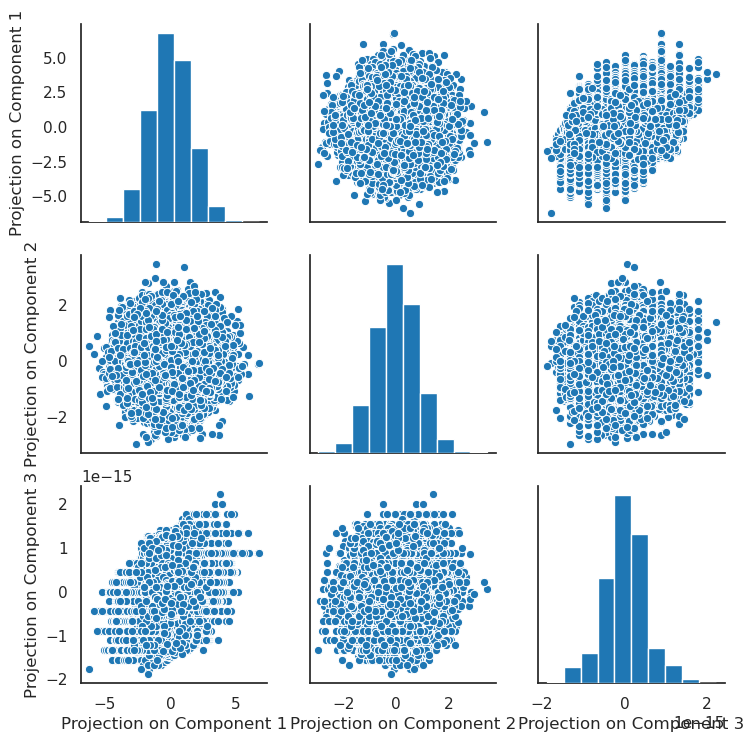

In [12]:
sns.pairplot(hwdf_PCA)
plt.show()

In [13]:
hwdf_PCA.corr().style.background_gradient(cmap='coolwarm')

,Projection on Component 1,Projection on Component 2,Projection on Component 3
Projection on Component 1,1.000000,0.000000,0.445836
Projection on Component 2,0.000000,1.000000,0.116663
Projection on Component 3,0.445836,0.116663,1.000000


As you can see, the correlations of the 3 principal components are now zero, meaning we have successfully de-correlated `hwdf` and obtained features that are linearly independent of each other.

Each component provides variance/information on a different direction. As we saw before that, the third component had a small projection, which means it doesn't provide much information about our original data `hwdf` in the new feature space.

Thus, we can remove the third dimension, while still keeping the vast majority of our data's information:


In [14]:
hwdf_PCA.drop('Projection on Component 3', axis=1, inplace=True)
hwdf_PCA.head()

,Projection on Component 1,Projection on Component 2
0,2.051774,-0.243847
1,-1.866218,1.117813
2,-3.133436,-0.794420
3,-1.696186,-0.748473
4,-1.803402,-1.058234


### Putting it all Together


Now that you have some intuition behind PCA, let's start from the beginning and understand the PCA-pipeline.

In **sklearn.decomposition.PCA**, there is a parameter called `whiten` which helps standardize your input data if you set `whiten = True`. You could also use `StandardScaler()` as a separate step before using PCA.


In [15]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(hwdf), index=hwdf.index, columns=hwdf.columns)
X.head()

pca = PCA()
X_PCA = pd.DataFrame(pca.fit_transform(X), index=X.index, columns=[f'Component {i}' for i in range(pca.n_components_)])
# (Remember it's technically "Projection onto Component {i}")
X_PCA.head()

,Component 0,Component 1,Component 2
Index,,,
1,2.051774,-0.243847,4.480501e-15
2,-1.866218,1.117813,2.227133e-13
3,-3.133436,-0.794420,-5.116699e-17
4,-1.696186,-0.748473,6.323577e-16
5,-1.803402,-1.058234,4.926941e-16


By default, `sklearn.decomposition.PCA` sorts the components by their explained variance.

Let's analyze the explained variance ratios:


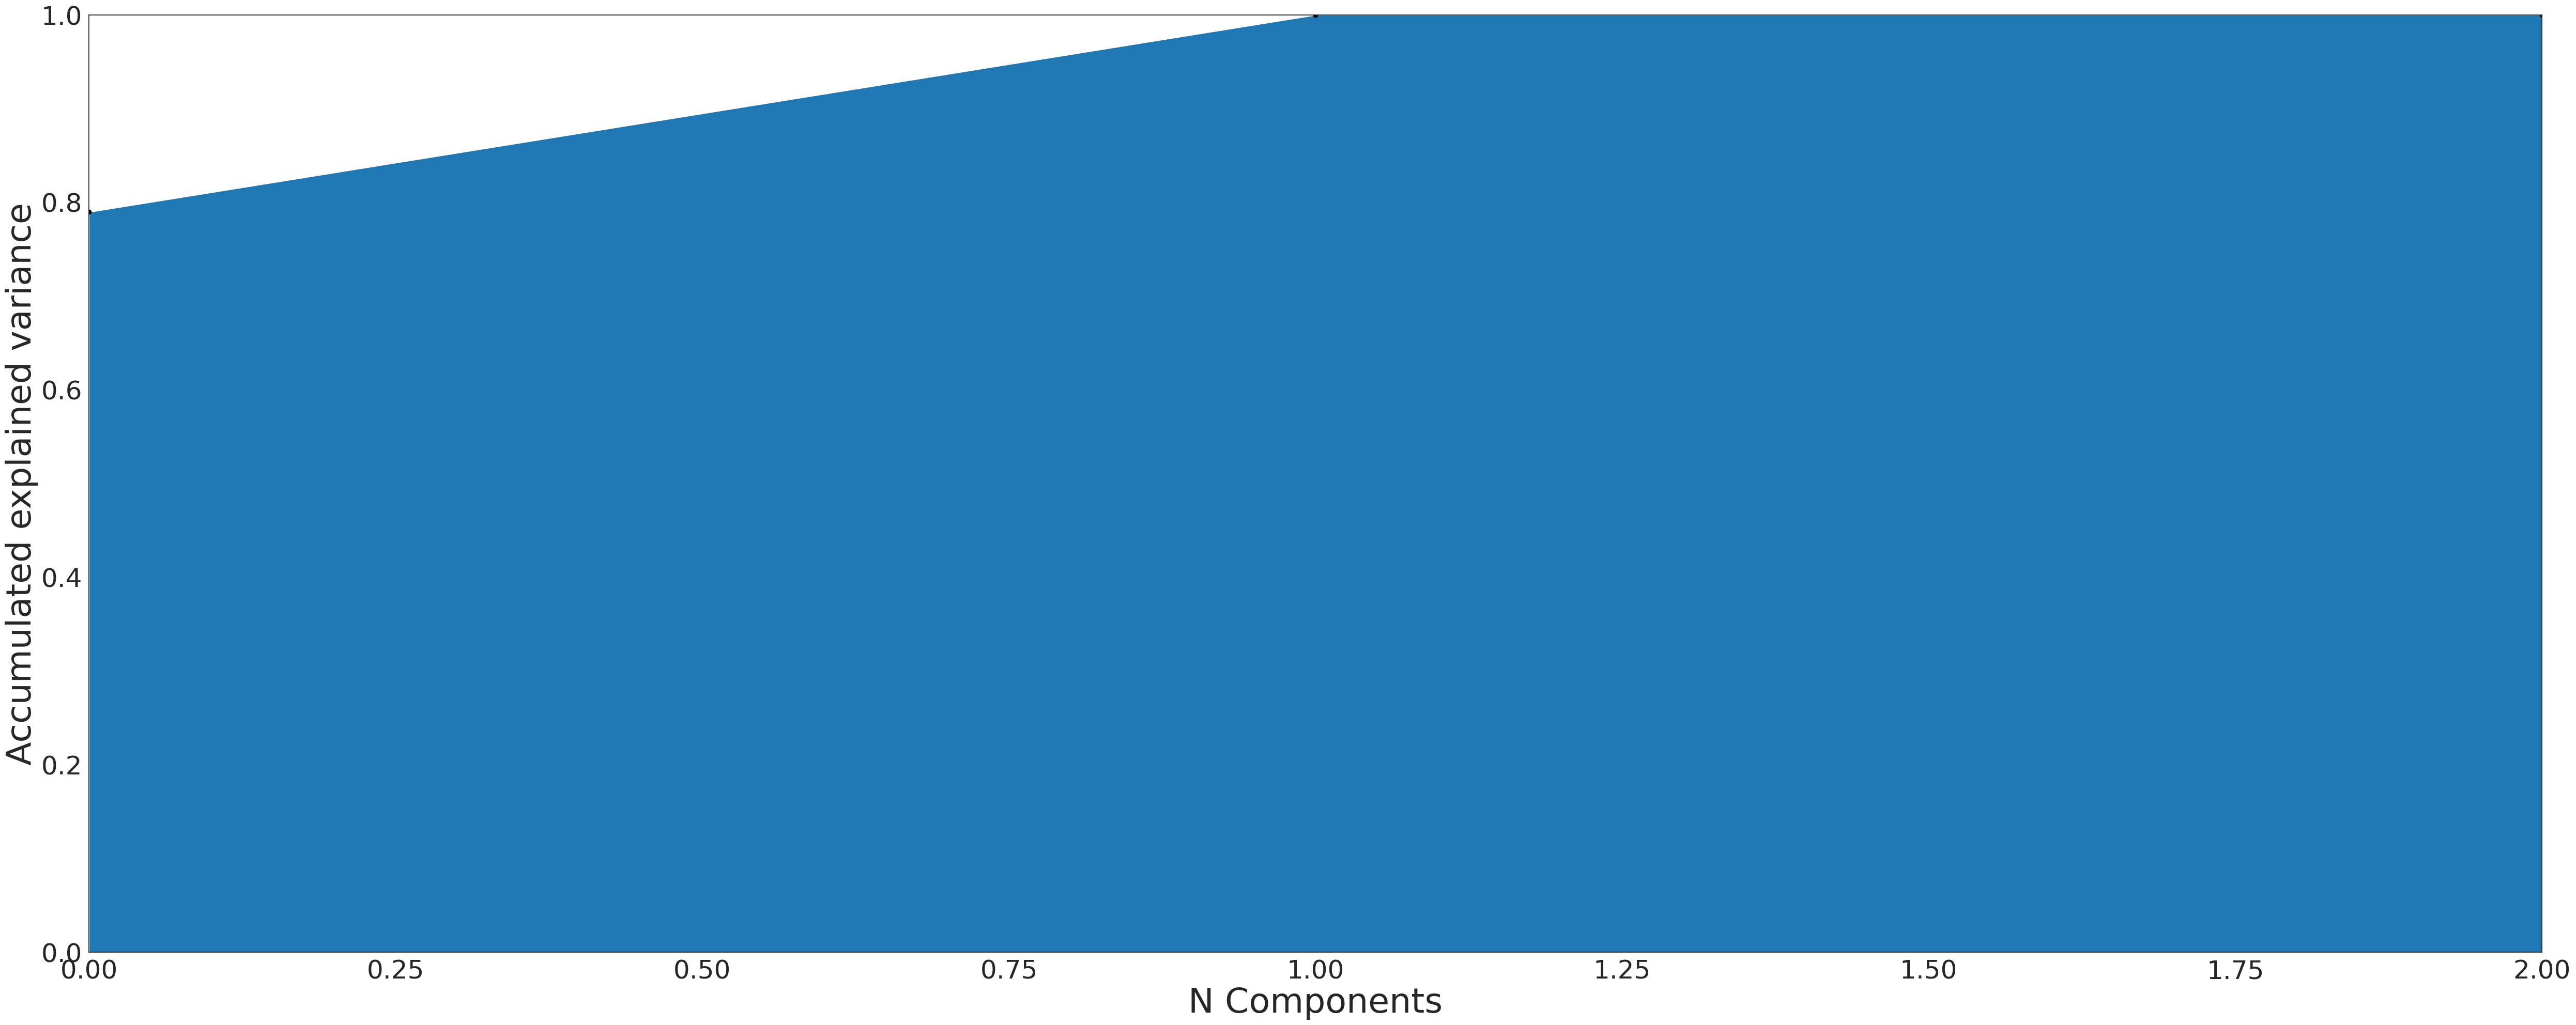

In [16]:
plot_explained_variance(pca)

Suppose a $99%$ threshold is sufficient for our task, let's see how many components (dimensions) we can drop:


In [17]:
threshold = 0.99
num = next(i for i, x in enumerate(accumulate(pca.explained_variance_ratio_), 1) if x >= threshold)
print(f'We can keep the first {num} components and discard the other {pca.n_components_-num},')
print(f'keeping >={100 * threshold}% of the explained variance!')

We can keep the first 2 components and discard the other 1,
keeping >=99.0% of the explained variance!


In [18]:
X_PCA.drop([f'Component {i}' for i in range(num, pca.n_components_)], axis=1, inplace=True)
X_PCA.head()

,Component 0,Component 1
Index,,
1,2.051774,-0.243847
2,-1.866218,1.117813
3,-3.133436,-0.794420
4,-1.696186,-0.748473
5,-1.803402,-1.058234


## Using PCA to Improve Facial Recognition

PCA is commonly used for Facial Recognition.

In this example, we will apply a method called "**Eigenfaces**"

The idea of *eigenfaces* is:

1.  You have images of faces of dimension $a \times b$ pixels.
2.  You "roll" these out into vectors of size $a \cdot n$.
3.  You apply PCA to the vectors.
4.  You determine how many principal components you want to train under; let's call this $C$.
5.  You train on the original image-vectors of size $a \cdot b$ projected onto your $C$ components, reshaped back to $a \times b$ bitmaps.


Load the Labeled Faces in the Wild (LFW) people datasetclassification


In [19]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Introspect the images arrays to find the shapes (for plotting)


In [20]:
# introspect the images arrays to find the shapes (for plotting)
N, h, w = lfw_people.images.shape
target_names = lfw_people.target_names

We load our features <code>X</code> and labels <code>y</code>. The images are flattened such that each one is a row in the NumPy array <code>X</code>


In [21]:
y = lfw_people.target
X = lfw_people.data
n_features = X.shape[1]

We plot out each class and an image belonging to that class:


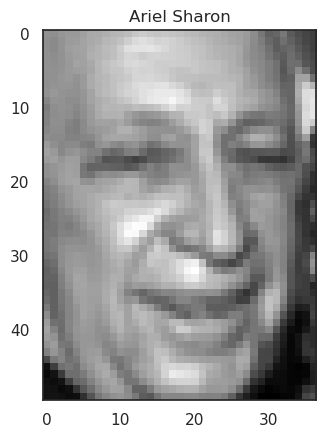

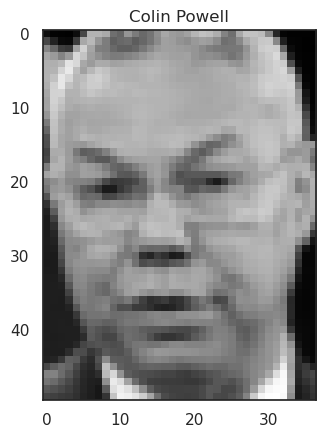

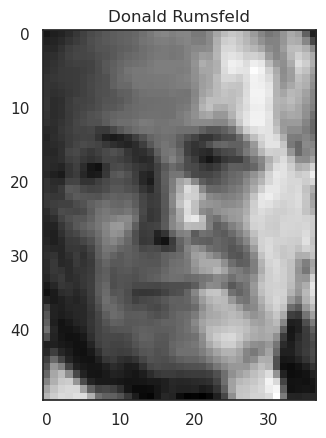

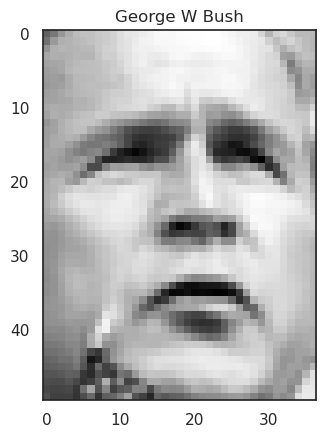

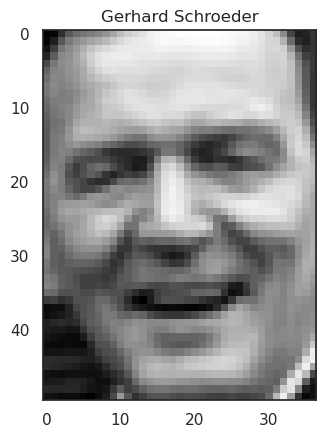

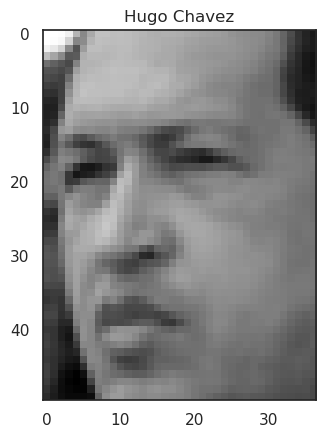

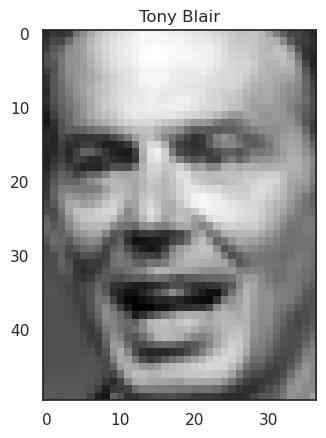

In [22]:
for person in np.unique(lfw_people.target):
    idx = np.argmax(lfw_people.target == person)
    plt.imshow(lfw_people.images[idx], cmap='gray')
    plt.title(lfw_people.target_names[person])
    plt.show()

We split the data into training and testing


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

We train a Support Vector Machines model for classification and use a random search method to find a set of optimal hyperparameters


In [24]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1)
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train, y_train)

We make a prediction using the test data:


In [25]:
y_pred = clf.predict(X_test)

Let's see how well our `SVC` did on the test data:


Text(46.24999999999999, 0.5, 'Truth Value')

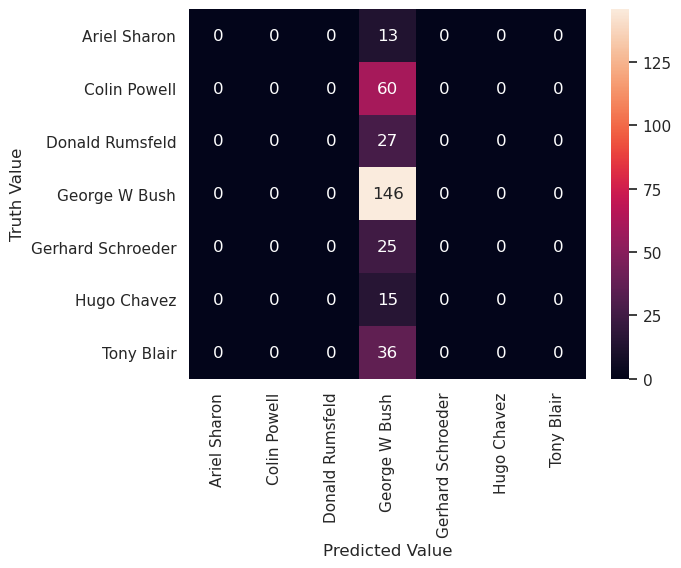

In [26]:
hmap = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    xticklabels=lfw_people.target_names,
    yticklabels=lfw_people.target_names,
    fmt='g'
)
hmap.set_xlabel('Predicted Value')
hmap.set_ylabel('Truth Value')

We see all the images are being classifed as George Bush. Clearly it's having trouble differentiating between the faces.


Now, let’s try using PCA, we fit a PCA model :


In [27]:
pca = PCA(svd_solver='full',  whiten=True).fit(X_train)

We find the projections on to each principle  component for a person int the dataset, we select the sample <code>person_index</code> :


In [28]:
person_index=1

In [29]:
Xhat=pca.transform(X[person_index,:].reshape(1, -1))

We can find the projections back to each component, i.e the inverse transform;as we use all the non-zero components the images are identical.


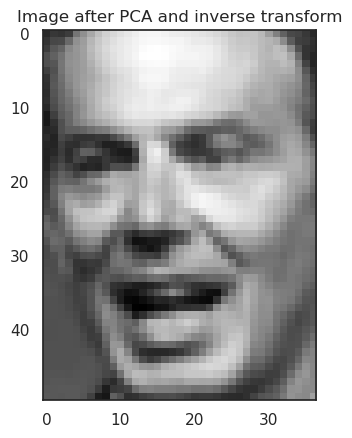

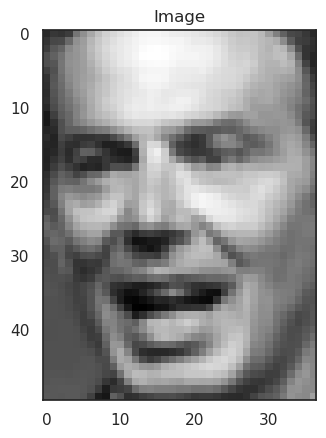

In [30]:
plt.imshow(pca.inverse_transform(Xhat).reshape(h, w), cmap='gray')
plt.title("Image after PCA and inverse transform"  ) 
plt.show()
plt.imshow(lfw_people.images[person_index],cmap='gray')
plt.title("Image")
plt.show()

We can use the Explained variance-ratio to determine the number of components to keep, we can plot it as Cumulative distribution.


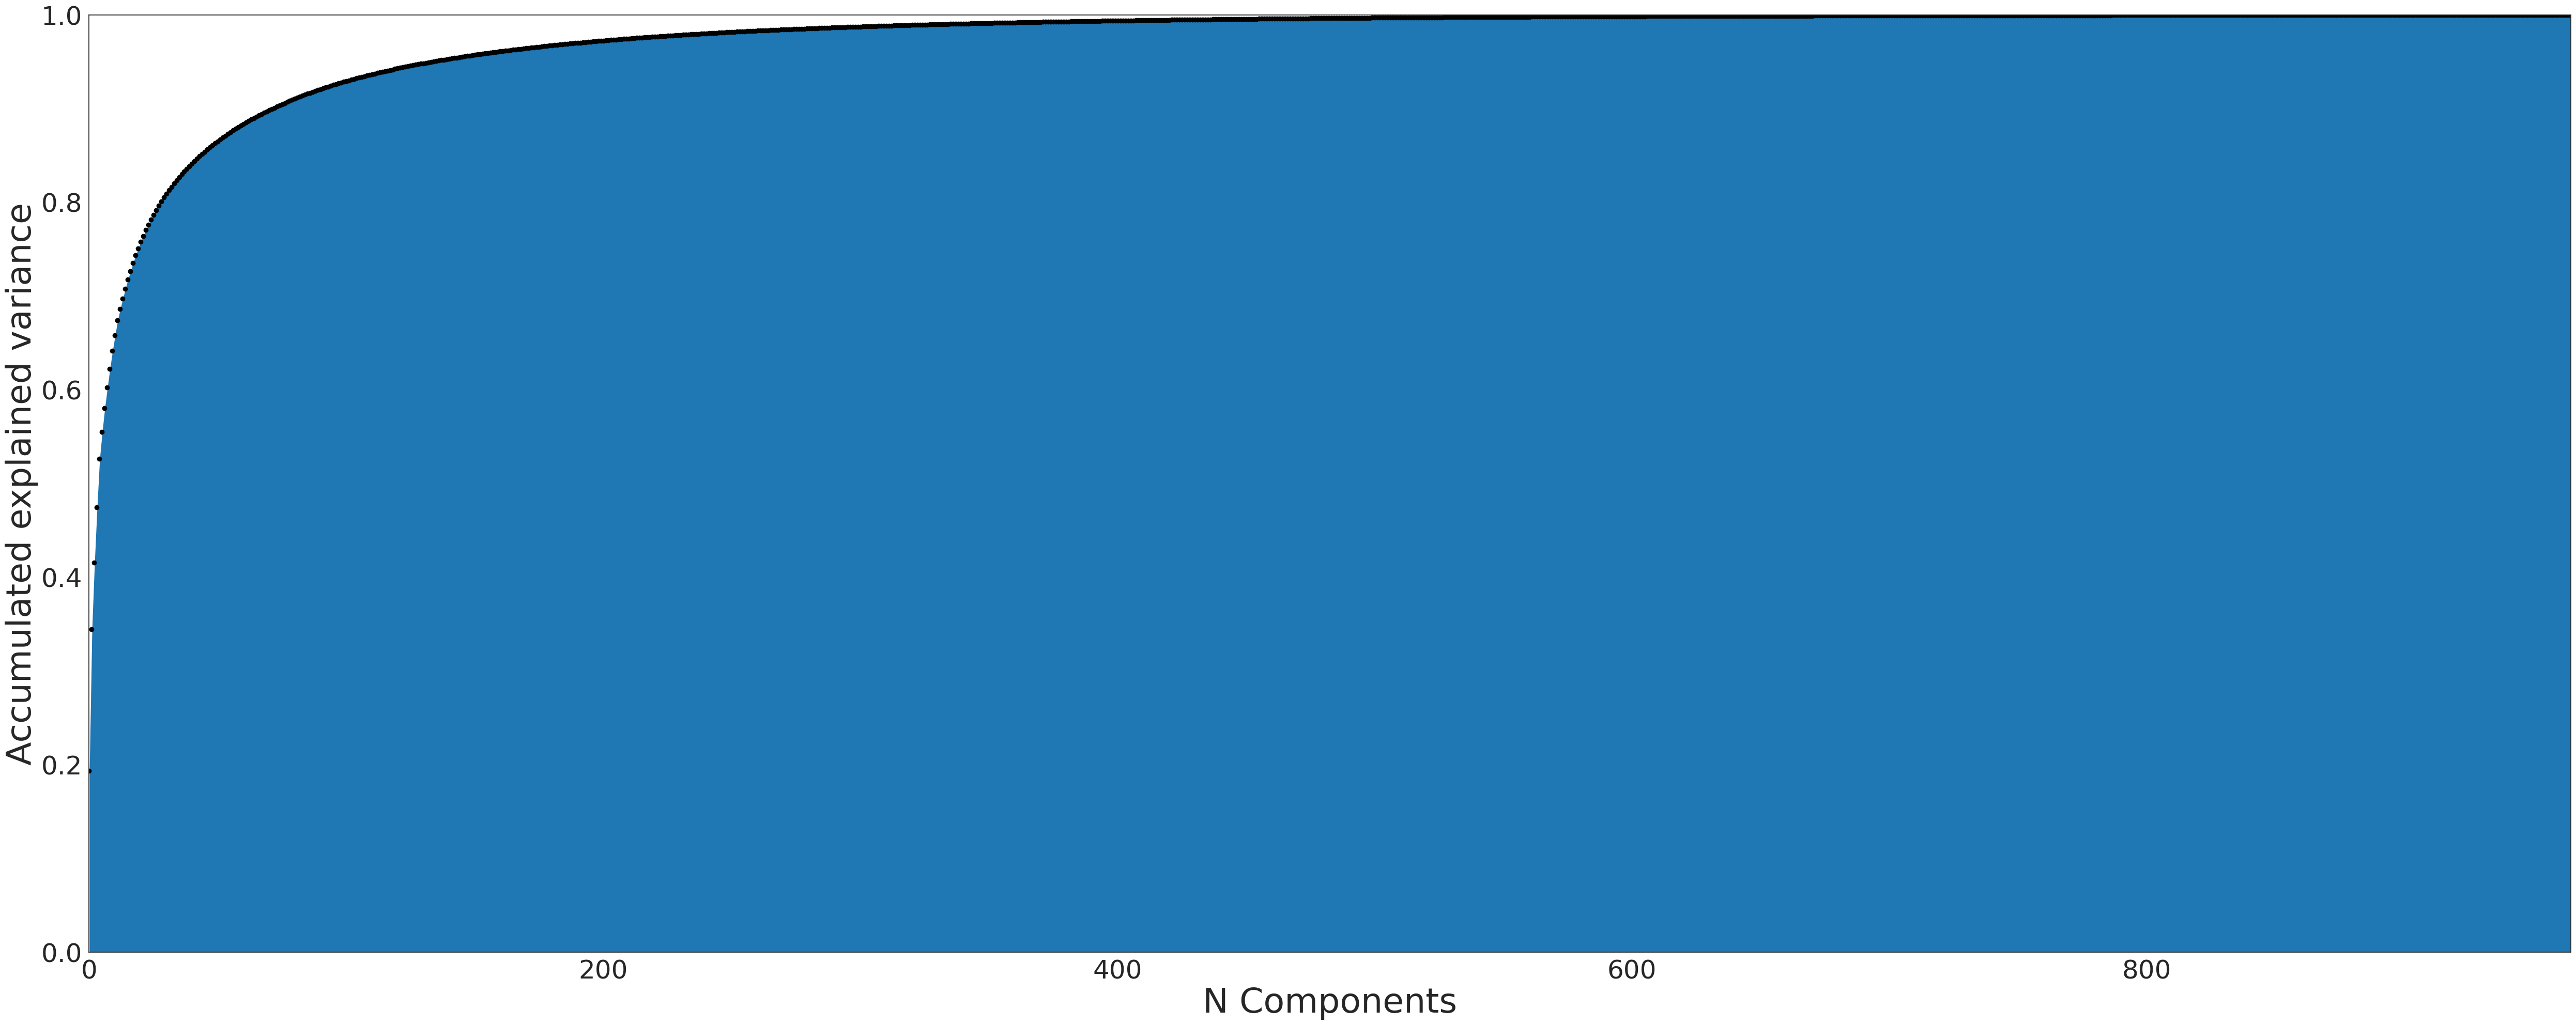

In [31]:
plot_explained_variance(pca)
plt.show()

It looks like 150 components explain over 95% of the variance, usually 80% will do, let’s try and visualize some components.

<p>
<b>Note:</b> you can use Cross-validation to select the number of components  
</p>


Let’s select the  components that explain over 60% of the variance


In [32]:
threshold = 0.60

This corresponds to 7 principle components


In [33]:
components = np.cumsum(pca.explained_variance_ratio_) < threshold
components.sum()

7

We can reshape the principle components to a rectangle  and plot them, remember the images are linear  combinations of these components


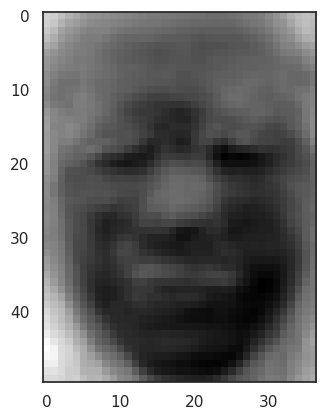

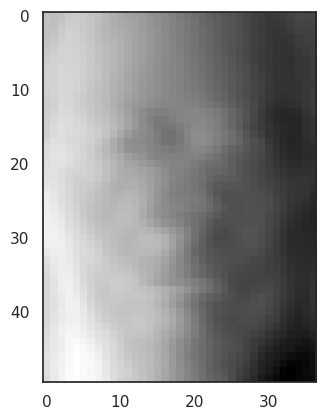

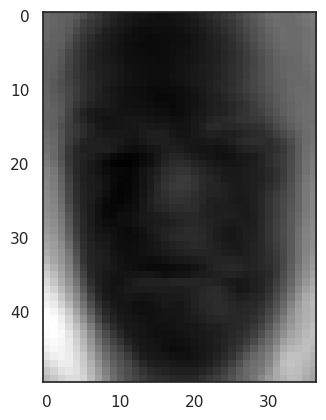

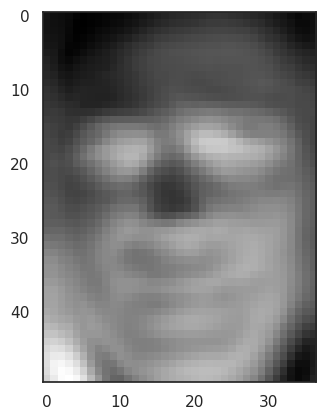

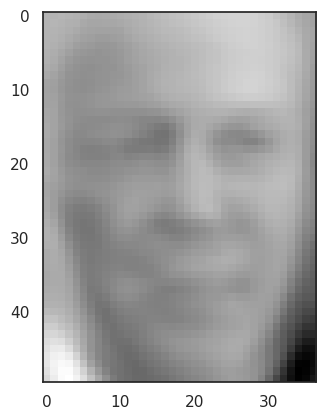

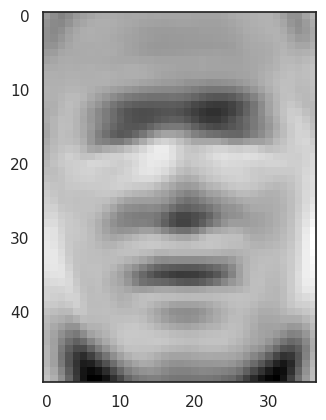

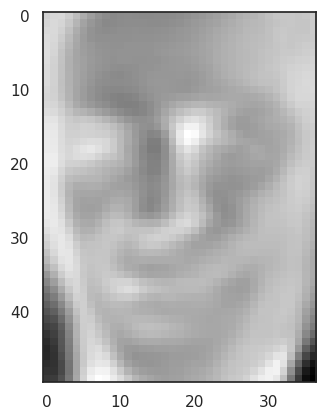

In [34]:
for component in pca.components_[components,:]:
    plt.imshow(component.reshape(h, w),cmap='gray')
    plt.show()

Let's now use PCA with `n_components = 150`:


In [35]:
pca = PCA(n_components=150, svd_solver="randomized", whiten=True).fit(X_train)

We apply the PCA transform on the training and testing data


In [36]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

**NOTE**: We can also transform the data back ("inverse_transform") to its original space, with the rest of the components to zero, then convert it to an image. For instance, let's look at one of the images using <code>person_index = 1</code>


In [37]:
person_index = 1

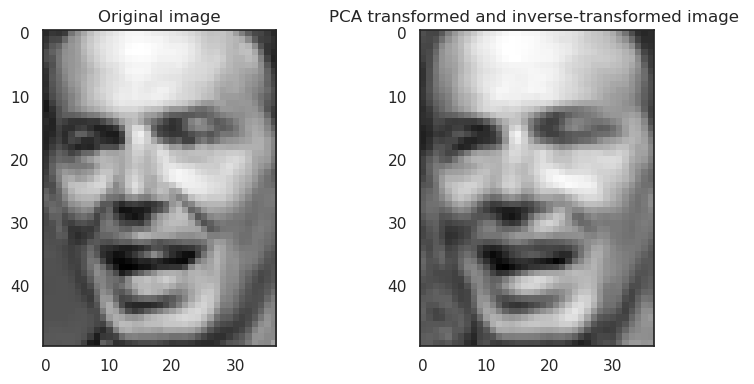

In [38]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(lfw_people.images[person_index,:,:],cmap='gray')
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(pca.inverse_transform(pca.transform(X[person_index ,:].reshape(1, -1))).reshape(h, w),cmap='gray')
plt.title("PCA transformed and inverse-transformed image ") 

plt.tight_layout()
plt.show()

We train the model and find the best Hyperparameters using the transformed data:


In [39]:
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)

clf = clf.fit(X_train_pca, y_train)

We see the model using PCA performs much better!


In [40]:
y_pred = clf.predict(X_test_pca)

Text(46.24999999999999, 0.5, 'Truth Value')

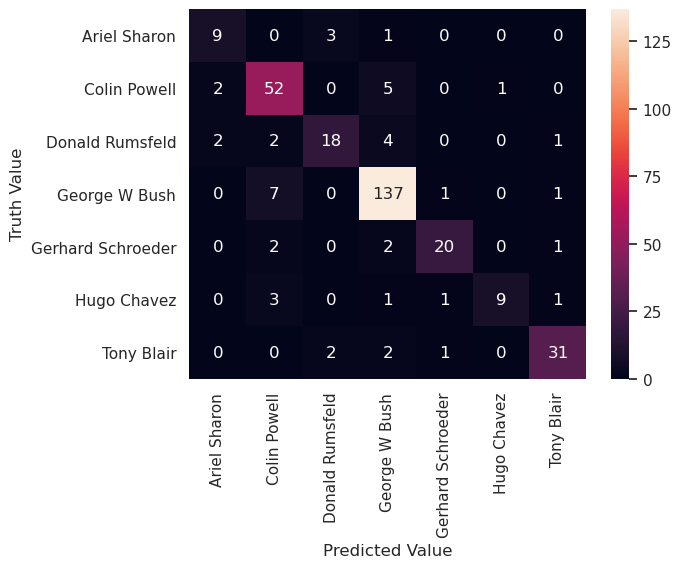

In [41]:
hmap = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    xticklabels=lfw_people.target_names,
    yticklabels=lfw_people.target_names,
    fmt='g'
)
hmap.set_xlabel('Predicted Value')
hmap.set_ylabel('Truth Value')

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By     | Change Description          |
| ----------------- | ------- | -------------- | --------------------------- |
| 2021-12-20        | 0.1     | Sam Prokopchuk | Complete Exercises' content |
| 2022-05-20        | 0.2     | Roxanne Li     | Review and edit             |
| 2022-07-15        | 0.2     | Svitlana K     | Review and edit             |


Copyright © 2021 IBM Corporation. All rights reserved.
